In [1]:
# utils
import requests
import datetime
import time
import pickle
from tqdm import tqdm
from voyagerOne import utils
from fuzzywuzzy import fuzz, process

# data manip
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# viz
import matplotlib.pyplot as plt
import seaborn as sns

# params
get_new_data = True

/Users/arrakis/opt/anaconda3/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Get draft positions

In [4]:
year_start = 2000
year_end = 2023

if get_new_data:
    # scrape pro-football-reference for draft positions in time window
    years = list(range(year_start,year_end+1))

    # loop through years and store in list of dfs
    all_dfs = []

    for y in years:
        base = f'https://www.pro-football-reference.com/years/{y}/draft.htm'
        dfs = pd.read_html(base, header=1)
        for frame in dfs:
            frame['draft_year'] = y
        all_dfs.append(dfs)
        time.sleep(0.1)

    expand = [x for y in all_dfs for x in y] # flatten df list

    # concatenate into a single df
    draft = pd.DataFrame()

    for frame in expand:
        draft = pd.concat([draft, frame])

    draft = utils.clean_cols(draft)
    draft = draft[['draft_year', 'rnd','pick', 'tm', 'player', 'pos','g']].copy() # grab subset
    draft = utils.clean_cols(draft) # underscore and lower case cols

    #convert cols to numeric
    draft['pick'] = pd.to_numeric(draft['pick'], errors='coerce')
    draft['g'] = pd.to_numeric(draft['g'], errors='coerce')
    draft['rnd'] = pd.to_numeric(draft['rnd'], errors='coerce')
    draft = draft.dropna()

    draft.to_pickle(f'data/draft_data_{year_start}-{year_end}.pkl')

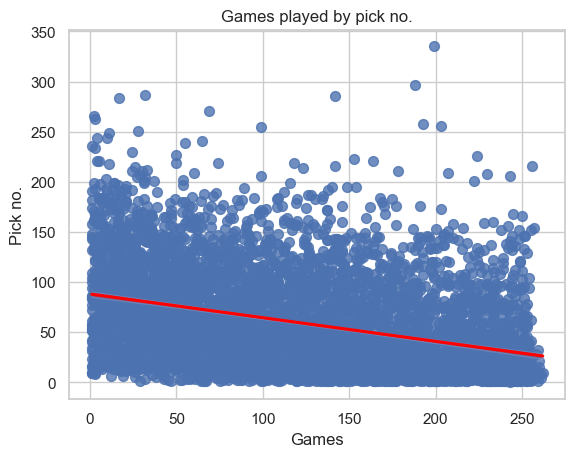

In [5]:
sns.set(style="whitegrid")  # Set the style

# Create the scatter plot with a trendline
sns.regplot(x='pick', y='g', data=draft, scatter_kws={'s': 50}, line_kws={'color': 'red'})

plt.xlabel('Games')
plt.ylabel('Pick no.')
plt.title('Games played by pick no.')
plt.show()

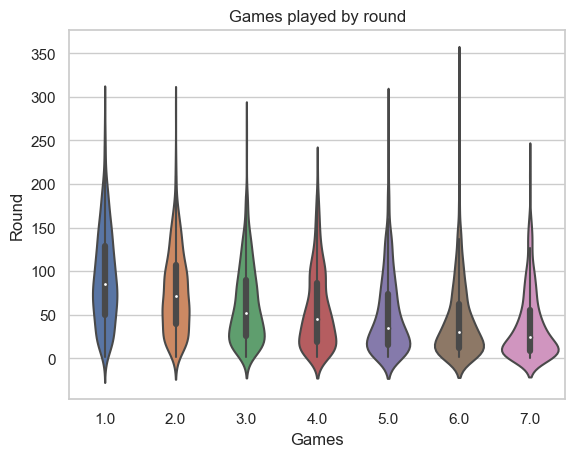

In [6]:
# Assuming 'df' is your DataFrame and 'x_column' and 'y_column' are the columns for x and y values
sns.set(style="whitegrid")  # Set the style

# Create the violin plot
sns.violinplot(x='rnd', y='g', data=draft)

plt.xlabel('Games')
plt.ylabel('Round')
plt.title('Games played by round')
plt.show()

## Get contract data

In [114]:
# same approach as draft years, except loop through positions
if get_new_data:
    positions = [
        'running-back',
        'quarterback',
        'wide-receiver',
        'tight-end',
        'center',
        'left-tackle',
        'left-guard',
        'right-guard',
        'right-tackle',
        'interior-defensive-line',
        'edge-rusher',
        'linebacker',
        'safety',
        'cornerback',
        ]

    pos_dict = {
        'running-back':'RB',
        'quarterback':'QB',
        'wide-receiver':'WR',
        'tight-end':'TE',
        'center':'C',
        'left-tackle':'T',
        'left-guard': 'G',
        'right-guard': 'G',
        'right-tackle': 'T',
        'interior-defensive-line':'DT',
        'edge-rusher': 'DE',
        'linebacker': 'LB',
        'safety':'S',
        'cornerback': 'CB',
    }

    all_dfs = []

    for pos in tqdm(positions):
        url = f'https://overthecap.com/contract-history/{pos}'
        data = pd.read_html(url, header=0)
        for frame in data:
            frame['pos'] = pos_dict[pos]
            all_dfs.append(frame)

    data = pd.DataFrame()

    for frame in all_dfs:
        data = pd.concat([data, frame])

    # clean 
    contracts = data[['Player', 'Team', 'pos', 'Year Signed', 'Value', 'Guaranteed']].copy()
    contracts = utils.clean_cols(contracts)
    
    contracts['year_signed'] = pd.to_numeric(contracts['year_signed'], errors='coerce')
    contracts = contracts[contracts['year_signed']!=0]
    contracts['value'] = contracts['value'].str.replace('[\$,]', '', regex=True).astype(int)
    contracts['gtd'] = contracts['guaranteed'].replace('[\$,]', '', regex=True).astype(int)
    contracts = contracts.drop(columns=['guaranteed'])

    ## get nfl cap history
    url = 'https://www.spotrac.com/nfl/cba/'
    cap_data = pd.read_html(url)[0]

    cap = cap_data[['Year', 'Cap Maximum']].copy()
    cap.columns = ['yr', 'cap']
    cap['cap'] = cap['cap'].str.replace('[\$,]', '', regex=True)
    cap['cap'] = pd.to_numeric(cap['cap'], errors='coerce')
    cap['cap'] = cap['cap'].interpolate(method='linear') # some years are missing, so interpolate for missing

    # merge salary cap to contracts and divide guaranteed contract value into cap to normalize contract
    # call normalized guranteed value gtd_norm
    contracts = contracts.merge(cap, how='left', left_on='year_signed', right_on='yr')
    contracts = contracts.drop(columns=['yr'])
    contracts['gtd_norm'] = contracts['gtd'] / contracts['cap']
    contracts['value_norm'] = contracts['value'] / contracts['cap']
    contracts = contracts.drop(columns=['cap'])
    contracts.loc[contracts['team'].str.contains('/'), 'team'] = contracts.loc[contracts['team'].str.contains('/'), 'team'].str.split('/', expand=True)[1] #slashes indicate a trade, where the first team is the recipient

    current_date = datetime.date.today()

    # write to pickle with today's date
    contracts.to_pickle(f'data/contracts_{current_date.year}_{current_date.month}_{current_date.day}')
    

100%|██████████| 14/14 [02:40<00:00, 11.48s/it]


TypeError: cannot concatenate object of type '<class 'str'>'; only Series and DataFrame objs are valid

## Join contracts to draft

### team abbrevs and position mapping

In [312]:
team_abbrevs = {
    'Lions':'DET', 
    'Broncos':'DEN', 
    'Cowboys':'DAL', 
    'Rams': 'LAR', 
    'Vikings':'MIN',
    'Jets':'NYJ',
    'Titans':'TEN',
    'Commanders':'WAS',
    'Chargers':'LAC',
    'Colts':'IND',
    'Steelers':'PIT',
    'Saints':'NO',
    'Seahawks':'SEA',
    'Giants':'NYG',
    'Eagles':'PHI',
    'Bengals':'CIN', 
    'Cardinals':'ARI',
    'Texans':'HOU',
    'Panthers':'CAR', 
    'Browns':'CLE',
    'Packers':'GB',
    '49ers':'SF',
    'Bears':'CHI',
    'Jaguars':'JAX',
    'Raiders':'LV',
    'Ravens':'BAL',
    'Bills':'BUF', 
    'Chiefs':'KC',
    'Falcons':'ATL',
    'Buccaneers':'TB',
    'Dolphins':'MIA', 
    'Patriots':'NE',
    'NWE':'NE',
    'SDG':'LAC',
    'STL':'LAR',
    'GNB':'GB',
    'OAK':'LV',
    'NOR':'NO',
    'SFO':'SF',
    'KAN':'KC',
    'TAM':'TB',
    'LVR':'LV',
    'NYJ': 'NYJ',
    'SEA': 'SEA',
    'ATL': 'ATL',
    'CIN': 'CIN',
    'IND': 'IND',
    'BUF': 'BUF',
    'HOU': 'HOU',
    'CAR': 'CAR',
    'TEN': 'TEN',
    'DEN': 'DEN',
    'ARI': 'ARI',
    'PIT': 'PIT',
    'DAL': 'DAL',
    'MIN': 'MIN',
    'CHI': 'CHI',
    'NYG': 'NYG',
    'DET': 'DET',
    'MIA': 'MIA',
    'BAL': 'BAL',
    'CLE': 'CLE',
    'JAX': 'JAX',
    'WAS': 'WAS',
    'PHI': 'PHI',
    'LAR': 'LAR',
    'LAC': 'LAC',
    'NE':'NE', 
    'LV':'LV', 
    'SF':'SF', 
    'TB':'TB',
    'NO':'NO',
    'KC':'KC',
    'GB':'GB'
}

In [325]:
pos_map = {
    'DE':'DE',
    'QB':'QB',
    'RB':'RB',
    'WR':'WR',
    'DT':'DT',
    'G':'IOL',
    'TE':'TE', 
    'DB':'DB', 
    'T':'OT',
    'LB':'LB',
    'NT':'DT',
    'C':'IOL',
    'OL':'IOL',
    'OLB':'LB',
    'CB':'DB',
    'S':'DB',
    'ILB':'LB',
    'DL':'DE', 
    'SAF':'DB'
}

### Perform fuzzy match of names

In [129]:
if get_new_data:
    ## fuzzy match
    threshold = 90

    # create dict of players+pos, year and index
    # name: (year, index)
    draft = draft.reset_index()
    draft = draft.drop(columns=['index'])
    draft['search_key'] = draft['player'] + ', ' + draft['pos']
    draft_names = dict(zip(
        draft['search_key'],
        tuple(zip(
            draft['draft_year'], 
            draft.index))))

    # create column to store index of matching player names from draft
    contracts['id'] = int
    contracts['search_key'] = contracts['player'] + ', ' + contracts['pos']

    # use fuzzywuzzy's process.extractOne() to find the best match for each name
    # only search within contracts signed in the same year as draft year, to limit chance of false positives
    # unfortunately, players with the the same name will still get associated with one another
    # this can be slow
    matches = {}
    for name, item in tqdm(draft_names.items()):
        year = item[0]
        index = item[1]
        contract_subset = contracts.loc[contracts['year_signed']==year, ].copy() # get a subset of contracts signed in same year as draft year 
        contract_names = contract_subset['search_key'].values # get player names + pos from that year

        match = process.extractOne(name, contract_names, score_cutoff=threshold) # find match

        if match!=None:
            # find corresponding player in contracts
            contracts.loc[contracts['search_key']==match[0], 'id'] = index # assign draft index to id col for later joining
    
    contracts = contracts.dropna(subset='id')
    
    # merge dfs on matching_name
    draft['id'] = draft.index
    data = draft.merge(contracts[['id', 'year_signed', 'team', 'value', 'gtd', 'gtd_norm']], how='left', on='id')
    data = data.dropna()
    data = data.rename(columns={'team': 'signing_tm'})
    data = data[data['pick']!=0]
    data['signing_tm'] = data['signing_tm'].map(team_abbrevs) #map team names
    data['tm'] = data['tm'].map(team_abbrevs)
    data['pos'] = data['pos'].map(pos_map)

    # write new joined df
    data.to_pickle(f'data/combined_data_{year_start}-{year_end}.pkl')
    data.head()

  0%|          | 0/5321 [00:00<?, ?it/s]

100%|██████████| 5321/5321 [15:13<00:00,  5.83it/s] 


In [328]:
# group by player name and save that
data_grouped = data[['player', 'gtd_norm', 'draft_year', 'pos', 'pick','search_key', 'g', 'signing_tm']]\
        .groupby('search_key')\
        .agg({
            'player':'max',
            'draft_year':'mean',
            'gtd_norm': 'sum',
            'pos':'max',
            'pick':'mean',
            'signing_tm':'max',
            'g':'mean'})\
        .reset_index()  # group by player


In [329]:
data.to_pickle(f'data/grouped_by_player_{year_start}-{year_end}.pkl')

## Analysis 

### Second contract ranks

In [330]:
# work off of second contracts
# if I just use groupby.rank then players without a second contract will be missing
# however we want them to exist so we can see they had effectively a $0 second contract

# make sure there are two of each player
player_counts = data['player'].value_counts()
players_to_add = player_counts[player_counts < 2].index.to_list()

# add new rows for players without 2nd contracts
new_rows = data[data['player'].isin(players_to_add)].copy() # select from players to add list
# clear out contract and signing details
new_rows['year_signed'] = np.nan
new_rows['signing_tm'] = np.nan
new_rows['value'] = 0.
new_rows['gtd'] = 0.
new_rows['gtd'] = 0.

# append to frame
data = data.append(new_rows, ignore_index=True)

# get all second contracts
df = data[data.groupby('player')['year_signed'].rank() == 2]

# there are some duplicate player-signing years due to the contract dataset, remove those
df = df.drop_duplicates(subset=['search_key', 'year_signed'])

# drop any pick # for which there are fewer than 3 samples
pick_counts = df[['pick']].groupby('pick').size()
picks_to_drop = pick_counts[pick_counts < 5].index
df = df[~df['pick'].isin(picks_to_drop)]

/var/folders/4p/cnm8c74x2cscn3bny0pr_bvr0000gn/T/ipykernel_31297/1049239548.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(new_rows, ignore_index=True)


In [331]:
# now rank these second contracts within each draft year
# by sorting by value and using 'first', value is effectively used as the tiebreaker column
df.loc[:, 'contract_rank'] = df.sort_values(by='value_norm', ascending=False).groupby('draft_year')['gtd_norm'].rank(ascending=False, method='first')

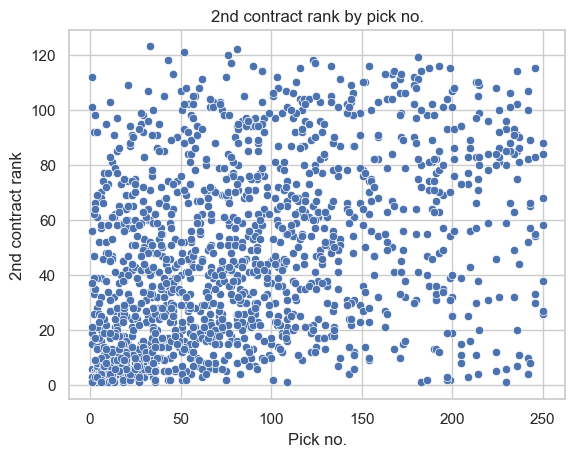

In [235]:
x = 'pick'
y = 'contract_rank'
draft_years = list(range(2000,2024))

sns.set(style="whitegrid")  # Set the style

# Create the scatter plot with a trendline
sns.scatterplot(x=x, y=y, data=df[df['draft_year'].isin(draft_years)])

plt.xlabel('Pick no.')
plt.ylabel('2nd contract rank')
plt.title('2nd contract rank by pick no.')
plt.show()

In [334]:
# scale gtds within position groups
# this is to control for the fact that some positions (e.g. QBs) get paid much more
scaler = MinMaxScaler()

cols=['gtd_norm','value_norm']

def f(x):
    scaler1=MinMaxScaler()
    new_cols = [x+'_scaled' for x in cols]
    x[new_cols] = scaler1.fit_transform(x[cols])
    return x

grouped = df[cols+['pos']].groupby('pos').apply(f)

df = df.join(grouped[['gtd_norm_scaled', 'value_norm_scaled']], how='left')


In [335]:
# now rank these second contracts within each draft year
# by sorting by value and using 'first', value is effectively used as the tiebreaker column
df.loc[:, 'contract_rank_scaled'] = df.sort_values(by='value_norm_scaled', ascending=False).groupby('draft_year')['gtd_norm_scaled'].rank(ascending=False, method='first')

In [336]:
# save dataset
df.to_pickle('data/all_2_contracts.pkl')

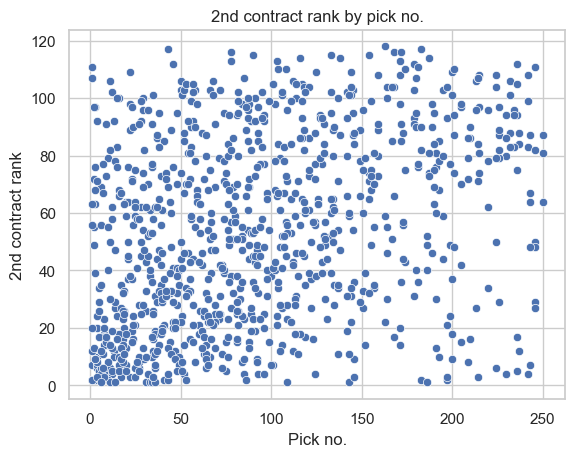

In [241]:
x = 'pick'
y = 'contract_rank_scaled'
draft_years = list(range(2012,2023))

sns.set(style="whitegrid")  # Set the style

# Create the scatter plot with a trendline
sns.scatterplot(x=x, y=y, data=df[df['draft_year'].isin(draft_years)])

plt.xlabel('Pick no.')
plt.ylabel('2nd contract rank')
plt.title('2nd contract rank by pick no.')
plt.show()

In [239]:
# summarize data across all picks
second_contracts = df[['pick', 'contract_rank_scaled']].groupby('pick').mean()
second_contracts = second_contracts.reset_index()

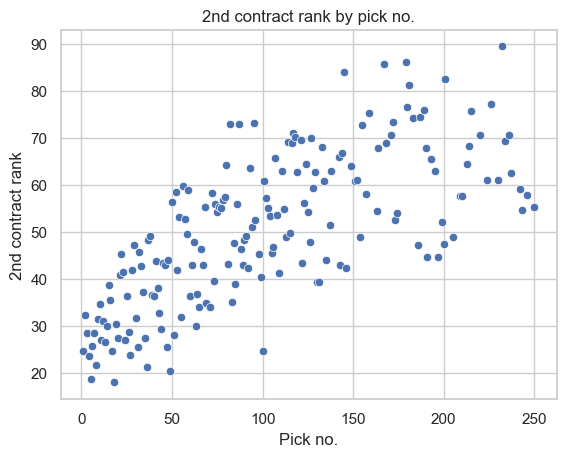

In [240]:
x = 'pick'
y = 'contract_rank_scaled'

sns.set(style="whitegrid")  # Set the style

# Create the scatter plot with a trendline
sns.scatterplot(x=x, y=y, data=second_contracts)

plt.xlabel('Pick no.')
plt.ylabel('2nd contract rank')
plt.title('2nd contract rank by pick no.')
plt.show()

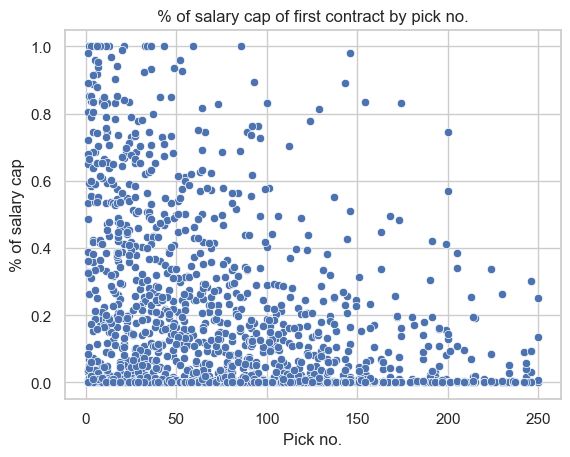

In [245]:
x = df['pick']
y = df['gtd_norm_scaled']

sns.set(style="whitegrid")  # Set the style

# Create the scatter plot with a trendline
sns.scatterplot(x=x, y=y, data=df)

plt.xlabel('Pick no.')
plt.ylabel('% of salary cap')
plt.title('% of salary cap of first contract by pick no.')
plt.show()

### Look at first contracts

In [337]:
# work off of second contracts
# if I just use groupby.rank then players without a second contract will be missing
# however we want them to exist so we can see they had effectively a $0 second contract

# get all second contracts
df1 = data[data.groupby('player')['year_signed'].rank() == 1]

# there are some duplicate player-signing years due to the contract dataset, remove those
df1 = df1.drop_duplicates(subset=['search_key', 'year_signed'])

# drop any pick # for which there are fewer than 3 samples
pick_counts = df1[['pick']].groupby('pick').size()
picks_to_drop = pick_counts[pick_counts < 5].index
df1 = df1[~df1['pick'].isin(picks_to_drop)]

In [338]:
# scale gtds within position groups
# this is to control for the fact that some positions (e.g. QBs) get paid much more
scaler = MinMaxScaler()

cols=['gtd_norm','value_norm']

def f(x):
    scaler1=MinMaxScaler()
    new_cols = [x+'_scaled' for x in cols]
    x[new_cols] = scaler1.fit_transform(x[cols])
    return x

grouped = df1[cols+['pos']].groupby('pos').apply(f)

df1 = df1.join(grouped[['gtd_norm_scaled', 'value_norm_scaled']], how='left')


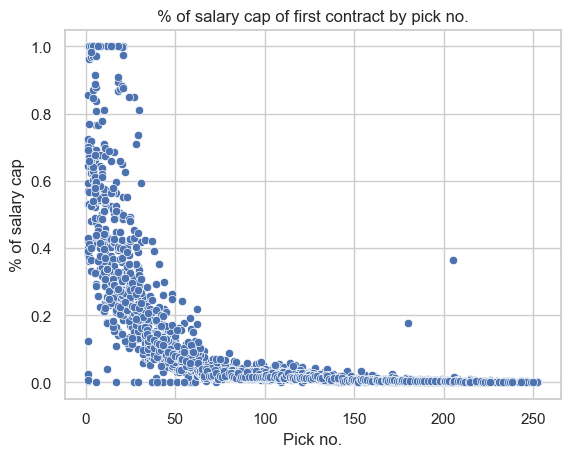

In [248]:
x = df1['pick']
y = df1['gtd_norm_scaled']

sns.set(style="whitegrid")  # Set the style

# Create the scatter plot with a trendline
sns.scatterplot(x=x, y=y, data=df1)

plt.xlabel('Pick no.')
plt.ylabel('% of salary cap')
plt.title('% of salary cap of first contract by pick no.')
plt.show()

In [339]:
# save dataset
df1.to_pickle('data/all_1_contracts.pkl')

In [260]:
np.sort(df1['pos'].unique())

array(['C', 'CB', 'DB', 'DE', 'DL', 'DT', 'G', 'ILB', 'LB', 'NT', 'OL',
       'OLB', 'QB', 'RB', 'S', 'SAF', 'T', 'TE', 'WR'], dtype=object)

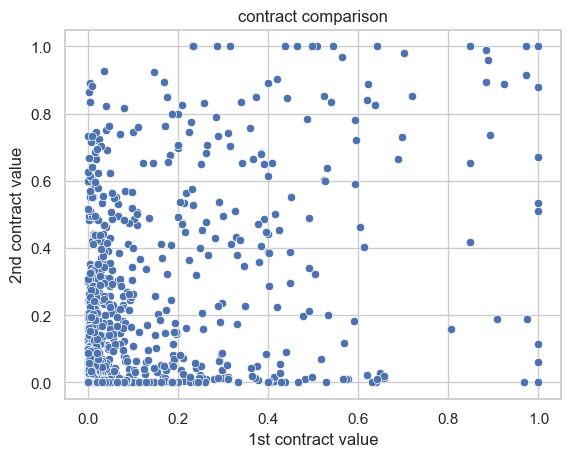

In [25]:
x = 'gtd1_norm_scaled'
y = 'gtd2_norm_scaled'

sns.set(style="whitegrid")  # Set the style

# Create the scatter plot with a trendline
sns.scatterplot(x=x, y=y, data=df[df['draft_year']> 2010])

plt.xlabel('1st contract value')
plt.ylabel('2nd contract value')
plt.title('contract comparison')
plt.show()

In [26]:
df['gtds_delta'] = df['gtd2_norm_scaled'] - df['gtd1_norm_scaled']

In [27]:
# create pick buckets because data is noisy otherwise
bins = np.linspace(0,df['pick'].max(), 25)
labels = list(range(1, 25))
df['pick_g'] = pd.cut(df['pick'], bins=bins, labels=labels)

delta_g = df[['pick_g', 'gtds_delta']].groupby('pick_g').mean().reset_index()

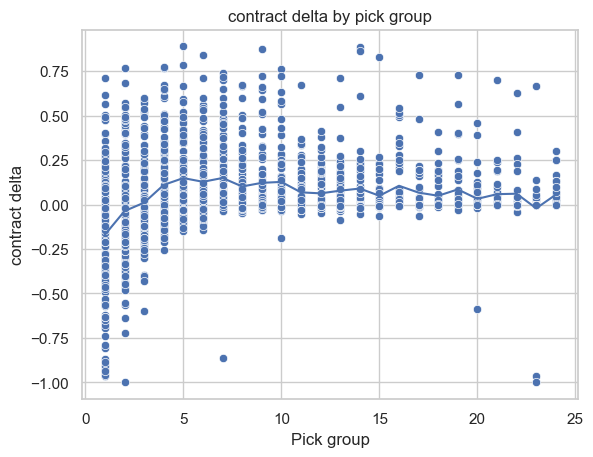

In [28]:
x = df['pick_g']
y = df['gtds_delta']

sns.set(style="whitegrid")  # Set the style

# Create the scatter plot with a trendline
sns.scatterplot(x=x, y=y, data=df)
sns.lineplot(x='pick_g', y='gtds_delta', data=delta_g)


plt.xlabel('Pick group')
plt.ylabel('contract delta')
plt.title('contract delta by pick group')
plt.show()

In [29]:
df['gtds_ratio'] = df['gtd2_norm_scaled'] / df['gtd1_norm_scaled']
df['gtds_ratio'] = df['gtds_ratio'].replace(np.inf, np.nan)

ratio_g = df[['pick_g', 'gtds_ratio']].groupby('pick_g').mean().reset_index()

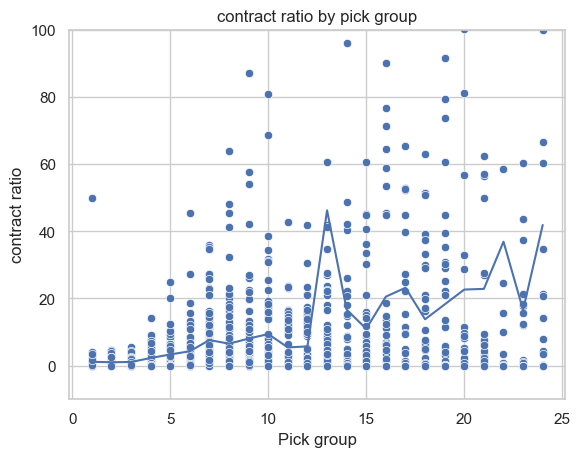

In [30]:
x = df['pick_g']
y = df['gtds_ratio']

sns.set(style="whitegrid")  # Set the style

# Create the scatter plot with a trendline
sns.scatterplot(x=x, y=y, data=df)
sns.lineplot(x='pick_g', y='gtds_ratio', data=ratio_g)

plt.ylim((-10,100))
plt.xlabel('Pick group')
plt.ylabel('contract ratio')
plt.title('contract ratio by pick group')
plt.show()

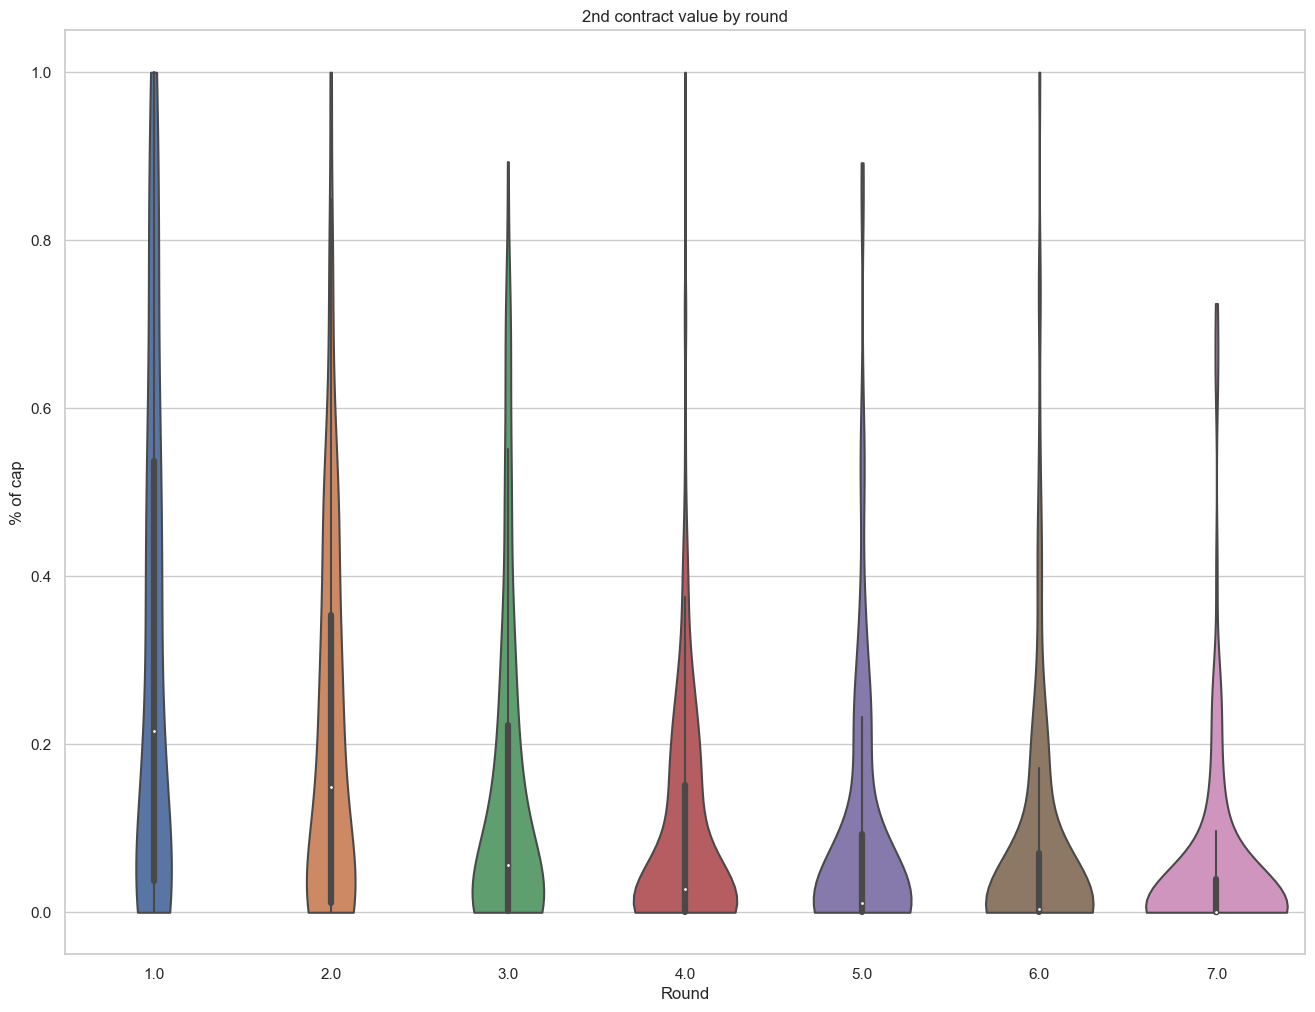

In [32]:
x = 'rnd'
y = 'gtd2_norm_scaled'

# Assuming 'df' is your DataFrame and 'x_column' and 'y_column' are the columns for x and y values
sns.set(style="whitegrid")  # Set the style
plt.figure(figsize=(16,12))

mean_values = df.groupby(x)[y].mean()
sorted_x_categories = mean_values.sort_values(ascending=False).index

# Create the violin plot
sns.violinplot(x=x, y=y, data=df, cut=0, order=sorted_x_categories)

plt.xlabel('Round')
plt.ylabel('% of cap')
plt.title('2nd contract value by round')

plt.show()

In [33]:
df['gtds_delta'] = df['gtd2_norm_scaled'] - df['gtd1_norm_scaled']

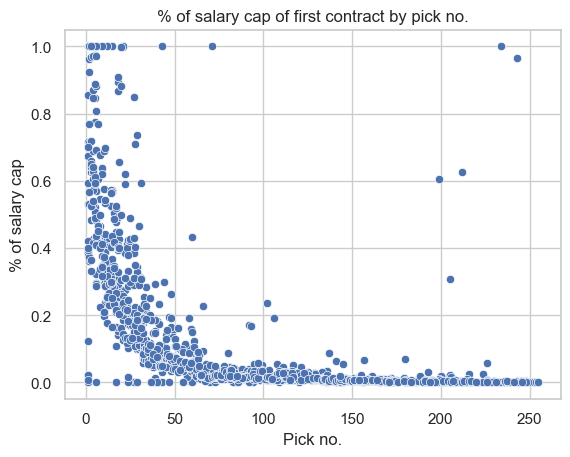

In [34]:
x = df['pick']
y = df['gtd1_norm_scaled']

sns.set(style="whitegrid")  # Set the style

# Create the scatter plot with a trendline
sns.scatterplot(x=x, y=y, data=df)

plt.xlabel('Pick no.')
plt.ylabel('% of salary cap')
plt.title('% of salary cap of first contract by pick no.')
plt.show()

In [269]:
import altair as alt
color_scheme = 'darkblue'
years = [2018,2019,2020,2022]

num_colors = len(years)
# Create a color scale based on the chosen color scheme
color_scale = alt.Scale(scheme=color_scheme)

# Get the list of hex codes from the color scale
color_hex_codes = color_scale.range().to_dict()["values"]
selected_colors = np.linspace(0, len(color_hex_codes) - 1, num_colors, dtype=int)
selected_hex_codes = [color_hex_codes[index] for index in selected_colors]


years = list(range(selected_years[0], selected_years[1]+1))
year_color_mapping = pd.DataFrame({
    'year': years,
    'color': selected_hex_codes  # Example colors
})

# Create a color scale based on the color scheme
color_scale = alt.Scale(scheme=color_scheme)

# Define the color encoding based on the year-to-color mapping
color_encoding = alt.Color('year:N', scale=color_scale, legend=None)

# Create an Altair chart using the color encoding
chart = alt.Chart(year_color_mapping).mark_bar().encode(
    y='year:O',  # 'year' is used as both nominal and ordinal (discrete) axis
    x='count():Q',  # Sample count for demonstration
    color=color_encoding  # Use the defined color encoding
)

chart.show()


TypeError: 'UndefinedType' object is not callable

In [272]:
color_scale.to_dict()["values"]

KeyError: 'values'